<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [12]</a>'.</span>

In [1]:
from edc import check_compatibility
check_compatibility("user-0.21.0")

# ESA EO $\phi$- week 2020

# Side Event 2: Euro Data Cube - Hands-on Tutorial and Training Session
---

In the previous part of the session, you have already gained experience in navigating around the Euro Data Cube interface and using **GeoDB**. Now, we are going to show a use case example to demonstrate how you can combine some of what you have learnt with **Sentinel Hub Services**!

## Use Case Example: Deforestation in the Gran Chaco Region

In this Jupyter Notebook we are going to investigate deforestation events happening in the Gran Chaco region that spans across parts of eastern Bolivia, western Paraguay, northern Argentina and a small part of the Brazilian state of Mato Grosso. The region has one of the highest rates of deforestation in the world, mainly linked to the expansion of cattle farming. 

The following articles provide more context information on the subject: [Deforestation in Argentina’s Gran Chaco
](https://earthobservatory.nasa.gov/images/146731/deforestation-in-argentinas-gran-chaco), [Deforestation in Paraguay](https://earthobservatory.nasa.gov/images/92078/deforestation-in-paraguay), [WWF: Gran Chaco](https://www.worldwildlife.org/places/gran-chaco).



<img src="https://www.worldlandtrust.org/wp-content/uploads/2018/05/rs11163_massive_deforestation_photo_credits_oscar_rodas-scr_2-640x474.jpg">

Deforested parcels in the Gran Chaco forest region (credit: John Burton, WLT).

<br>
Throughout the following examples we will see how to:

- request satellite imagery using the Python wrapper to the Sentinel Hub API service
- easily request metadata concerning images over a given area and time frame
- extract basic statistical information for a given area and time frame

First, we will access the [Global Forest Watch](http://www.globalforestwatch.org/about/) dataset (saved as a GeoDB in EDC) on deforestation in Gran Chaco. The original version can be downloaded [here](https://data.globalforestwatch.org/datasets/gran-chaco-deforestation). The dataset, that runs from 2011 to early 2018, represents deforested areas as polygons, derived manually using 30-meter resolution Landsat images for the 55 scenes that cover the Gran Chaco.

To check the temporal and spatial accuracy of the polygons, we will select a small test subset in Paraguay and compare the polygons representing deforestation events in January 2018 to higher resolution Sentinel-2 images. In this section, we will see how to query data using Sentinel Hub's python package, and how to get metadata from the Catalog API to select the correct images without wasting resources/time. 

We will then show you how to use the brand-new data fusion capabilities of Sentinel Hub services to mitigate the drawbacks of using optical sensors for deforestation detection.

Finally, we will investigate the time-series of Sentinel-2 images, deriving NDVI (Normalized Difference Vegetation Index) to see if the deforestation event can be automatically detected.

### Load necessary libraries

In [2]:
# EDC
from edc import setup_environment_variables
from xcube_geodb.core.geodb import GeoDBClient

# Sentinel Hub Py
from sentinelhub import (SHConfig, BBox, bbox_to_dimensions, CRS, SentinelHubRequest, DataSource, MimeType, FisRequest)
from sentinelhub.geometry import Geometry

# Utilities
from pathlib import Path
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
from datetime import datetime as dt
import pandas as pd
import numpy as np
import tarfile

# Geographical libraries
import geopandas
from pyproj import Proj, transform
from shapely.geometry import shape, box
from shapely.ops import unary_union

# Plotting
import IPython
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib import colors
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Rasterio
import rasterio
from rasterio.plot import show
import rasterio.features
from scipy.ndimage import morphology

### Setup environment variables

There are several options to set up your Sentinel Hub credentials, depending on how you want to access the services. In this workflow, as we will be working with the `sentinelhub-py` package to run requests in Python, we set up an `SHConfig` object that will take care of identification with the services for us. Therefore, we assign the identification parameters provided by EDC to the `SHConfig` object.

In [3]:
# Get identification parameters from EDC
setup_environment_variables()

# Assign environement variables for later use
sh_client_id = %env SH_CLIENT_ID
sh_client_secret = %env SH_CLIENT_SECRET
sh_instance_id = %env SH_INSTANCE_ID

# Setup SH services access
config = SHConfig()

config.sh_client_id = sh_client_id
config.sh_client_secret = sh_client_secret
config.instance_id = sh_instance_id

API credentials have automatically been injected for your active subscriptions.  
The following environment variables are now available:
* `GEODB_API_SERVER_PORT`, `GEODB_API_SERVER_URL`, `GEODB_AUTH_AUD`, `GEODB_AUTH_CLIENT_ID`, `GEODB_AUTH_CLIENT_SECRET`, `GEODB_AUTH_DOMAIN`
* `SH_CLIENT_ID`, `SH_CLIENT_NAME`, `SH_CLIENT_SECRET`, `SH_INSTANCE_ID`

The following additional environment variables have been loaded from `~/custom.env`:
* `AWS_BUCKET`
* `DAPA_URL`
* `DB_HOST`, `DB_NAME`, `DB_PASSWORD`, `DB_USER`
* `OGC_EDC_URL`
* `REFERENCE_DATA`


Next, we set up access to the GeoDB, using `GeoDBClient` as shown in the previous section of this training session.

In [4]:
geodb = GeoDBClient()

---

## Request a truecolor image as overview of the selected area

Now that the credentials are set up, it is possible to request satellite images.

We will start by plotting an overview True Color RBG image from Sentinel-2 of the area that we will be working on.

The *Sentinel Hub Process API* will need the following information for a valid request:

+ An **AOI** (area of interest): that contains the location's coordinates (polygon or bounding box). The image size is pre-calculated according to the resolution desired.
+ **Evalscript** in which you specify the data products and their visualisation
+ **Request body** with parameters about the location and time

### Define coordinates for area of interest and create a bbox object

In [5]:
# Select the coordinates (lower-left, upper right) of our AOI
aoi_bbox = [-60.28157336, -21.27560428, -60.12293070, -21.18495133]

# Set AOI overview bbox
resolution = 10
aoi_overview = BBox(bbox=aoi_bbox, crs=CRS.WGS84)  # Make a BBox object of the list of coordinates
aoi_overview_size = bbox_to_dimensions(aoi_overview, resolution=resolution)  # Automatically calculate the output size in px

print(f"Output image size: {aoi_overview_size[0]} * {aoi_overview_size[1]} px")

Output image size: 1665 * 975 px


### Evalscript creation

An [Evalscript](https://docs.sentinel-hub.com/api/latest/evalscript/v3/) is a piece of Javascript code that allows you to define the input and output parameters of the data you would like to query, as well as specifying the processing to be applied to the satellite images.

For the evalscript you must specify at least the two following functions:

+ setup function: this sets up the input (i.e. which bands to call) and output settings (number of bands to return, format, etc...).
+ evaluatePixel function - this function is where you specify the processing (to derive new information from the images, or for visualisation) to be applied to the images.

In the following Evalscript, we want to return an RGB True Color image. In the `setup` function, we will specify that we want to use the Red (`B04`), Green (`B03`) and Blue (`B02`) bands of Sentinel-2. Since we want a three-channel image (RGB), we specify that our output will have three bands. We use the convenient `AUTO` sample type for the returned data, as we are just going to visualise it. With `AUTO` values should range from 0-1, which will then automatically be stretched from the interval [0, 1] to [0, 255] and written into a UINT8 raster.

Because the image would be too dark if we return directly the band values scaled from 0 to 255, we apply a gain (multiplying the values by 3.5). This is just for visualisation purposes.

In [6]:
evalscript_true_color = """
//VERSION=3

// Set up the input and output settings

function setup() {
  return {
    input: ["B02", "B03", "B04"],  //define input bands
    output: { bands: 3, sampleType: SampleType.AUTO}  //define amount of channels in output image (RGB = 3)
  };
}

// Map the input bands to the values in the output raster

function evaluatePixel(sample) {
  let gain = 3.5;
  return [gain * sample.B04, gain * sample.B03, gain * sample.B02];    //map bands 4, 3, 2 to RGB channels and multiply by 3.5 for enhanced truecolor visualisation
}
"""

### Request body creation

The run the Evalscript, we need to define the payload, or data parameters to send to Sentinel Hub Services. The Sentinel Hub python package simplifies the writing of the payload, by using the `SentinelHubRequest` class to pass the following input parameters:

1. the created evalscript
2. input data (data source and time interval)
3. define the output (name and format)
4. define bbox
5. size of the requested image
6. identification with the SHConfig object


In [7]:
request = SentinelHubRequest(evalscript=evalscript_true_color,
                             input_data=[SentinelHubRequest.input_data(data_source=DataSource.SENTINEL2_L2A,
                                                                       time_interval=("2017-12-31",
                                                                                      "2017-12-31"))],
                            responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
                            bbox=aoi_overview,  
                            size=aoi_overview_size,
                            config=config)

Now that the request is created, we just need to run it using the `get_data` method.

In [8]:
overview = request.get_data()

### Plot the requested image

By using `get_data` without any additional parameters saved the results to the `overview` variable. Let's plot it to look at the returned data.

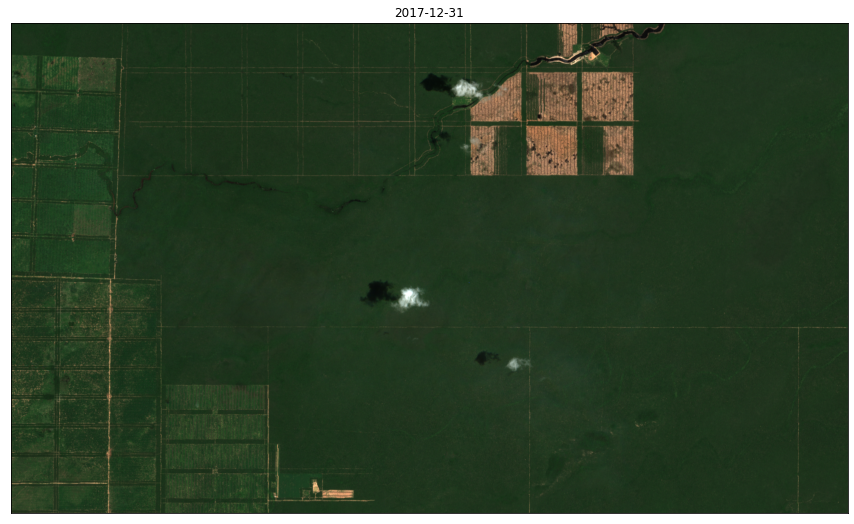

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
ax.imshow(overview[0])

# Plot configuration
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("2017-12-31")

plt.show()

### Quizz: can you figure out how to request a falsecolor infrared image?
Try to fill in the gaps in the evalscript below.

*Hint: To receive a falsecolor infrared image you need to map Sentinel-2 Band 8 (NIR) to the red channel, Band 4 (RED) to the green channel, and Band 3 (GREEN) to the blue channel*.

In [10]:
evalscript_false_color = """
//VERSION=3

function setup() {
  return {
    input: ["", "", ""],
    output: { bands: 3 }
  };
}

function evaluatePixel(sample) {
  let gain = 2.5;
  return [ , , ];
}
"""

Uncomment the following cell for the solution. Make sure to run the following cell twice, one time for fetching the solution and a second time for running the Evalscript.


In [11]:
# %load https://raw.githubusercontent.com/sentinel-hub/code-snippets/master/phiweek2020/Solution.py

Now that we have the Evalscript, let's run the request:

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [12]:
request = SentinelHubRequest(evalscript=evalscript_false_color,
                             input_data=[SentinelHubRequest.input_data(data_source=DataSource.SENTINEL2_L2A,
                                                                       time_interval=("2017-12-31",
                                                                                      "2017-12-31"))],
                            responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
                            bbox=aoi_overview,  
                            size=aoi_overview_size,
                            config=config)

overview_fc = request.get_data()

DownloadFailedException: Failed to download from:
https://services.sentinel-hub.com/api/v1/process
with HTTPError:
400 Client Error: Bad Request for url: https://services.sentinel-hub.com/api/v1/process
Server response: "{"error":{"status":400,"reason":"Bad Request","message":"S2L2A has no band ","code":"RENDERER_EXCEPTION"}}"

### Plot the False Color image 

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
ax.imshow(overview_fc[0])

# Plot configuration
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("2017-12-31")

plt.show()

---

## Get the collection from GeoDB and data preparation
In the next step we retrieve the prepared gran_chaco collection from GeoDB.

As a reminder, you can explore the original dataset [here](https://data.globalforestwatch.org/datasets/gran-chaco-deforestation/data?geometry=-60.601%2C-20.023%2C-59.293%2C-19.797).

### Check available collections in GeoDB

Using the `geodb` client, let's look at what collections are available.

In [ ]:
# Lets get already existing collections
geodb.get_my_collections()

### Query the collection by bbox to retrieve only the area we are interested in

We are interested in the `gran_chaco` GeoDB collection. However, we will not query it entirely in this exercise since we are only interested in a specific AOI that we defined further up. Therefore, not needing the whole dataset, we only retrieve the polygons that are contained in our area of interest by querying the dataset with our defined bbox.

In [ ]:
gran_chaco = geodb.get_collection_by_bbox('gran_chaco', database="phi_week", bbox=aoi_bbox, bbox_crs=4326, comparison_mode="contains")

Let's preview the collection subset that we have just queried.

In [ ]:
gran_chaco

### Data preparation

As we can see above, in the subset of the GeoDB that we queried, there are deforestation events detected in 2011, 2014, 2015, 2016, 2017 and 2018. Let's narrow down the dataset a little further and only select the polygons in 2018.

In the following cell, we convert the date strings to `datetime` objects to make the querying easier.

In [ ]:
# Convert the dates to datetime objects and store in a new column
gran_chaco["datetime"] = pd.to_datetime(gran_chaco["date"])

In [ ]:
# Select only polygons from 2018
gran_chaco_subset_2018 = gran_chaco[gran_chaco["datetime"].dt.year == 2018]

Now, we can preview the subset that we have selected based on the year 2018.

In [ ]:
gran_chaco_subset_2018

In [ ]:
# Plot all selected polygons
IPython.display.GeoJSON(gran_chaco_subset_2018.__geo_interface__)

Fun fact: thanks to Ipython, it is easy to zoom out to have an idea of the location of the polygons. Furthermore, you can click on an individual polygon to list the attributes of that specific shape in the dataframe.

---

## Query Catalog API for dates with  available Sentinel-2 data before and after the registered deforestation event

For our selected AOI, we will check if the registered deforestation date in the dataset that we are querying is correct. To do so, we will look at the closest cloud-free Sentinel images before and after the date assigned to the polygon (here, `2018-01-31`).

Rather than query all the Sentinel-2 images in a given period around the date of interest, which would be a waste of resources particularly in cloudy areas, we can use the Catalog API service to list metadata about the images that will guide our choice in the selection. The Catalog service allows us to return the dates of images intersecting the AOI, but other essential parameters, such as the scene's overall cloud cover.

### Create an OAuth2 session and create a token for it
In order to send a request to the Catalog API we need to create a token first. Let's start by creating an OAuth session.

In [ ]:
# Create a session
client = BackendApplicationClient(client_id=sh_client_id)
oauth = OAuth2Session(client=client)

 The token acts like an ID we provide the API with to verify us as a registered user. This token is temporary (about 1h) for security reasons. If when running a Catalog request an authentification error is thrown, just execute the following cell again to obtain a new token.

In [ ]:
# Get token for the session
token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_id=sh_client_id, client_secret=sh_client_secret)

### Create the Catalog API request
We specify the service endpoint URL, set the Content-Type to 'application/json' because we only want to receive a list of dates with available Sentinel-2 data within the selected period. We also set the `collection` that we want to query (here Sentinel-2 L1C), and the time range we are interested in.

In [ ]:
# Set the Catalog API url
catalog_url = "https://services.sentinel-hub.com/api/v1/catalog/"

# Set the header
headers = {
  'Content-Type': 'application/json'
}

# Set the Catalog request parameters
collections = "sentinel-2-l1c"
datetime= "2017-10-01T00:00:00Z/2018-02-15T23:59:59Z"  # We set a wide time range to get an idea of the available data

In [ ]:
# Run the catalog request
response = oauth.request("GET", f"https://services.sentinel-hub.com/api/v1/catalog/collections/{collections}/items?bbox={aoi_bbox[0]},{aoi_bbox[1]},{aoi_bbox[2]},{aoi_bbox[3]}&datetime={datetime}&limit=20", headers=headers)
catalog_results = response.json()

In [ ]:
# Fetch the dates and cloud cover values
available_data = []
for entry in catalog_results["features"]:
    available_data.append((entry["properties"]["datetime"], entry["properties"]["eo:cloud_cover"]))
    
print(available_data)

---

## Filter the available dates

We now have a list of images and their respective cloud cover available, we can filter out for the closest dates to the deforestation event marked in our database, taking in account the cloud cover. 

Let's select the images with less than 10% cloud cover over the entire scene.

In [ ]:
# Set the date of interest. Since all the dates are the same in our subset, we take the first one.
deforestation_date = dt.strptime(gran_chaco_subset_2018.date.values[0], "%Y-%m-%d")

# Cloud cover percentage filter
cc = 10

# We want to select the dates that have less than the set % of cloud cover
available_datetimes = [dt.strptime(x[0], "%Y-%m-%dT%H:%M:%SZ") for x in available_data if x[1] <= cc]

# Find the index before and after our date of interest
past_dates = [date for date in available_datetimes if date < deforestation_date]
future_dates = [date for date in available_datetimes if date >= deforestation_date]

before_ind = available_datetimes.index(max(past_dates))
after_ind = available_datetimes.index(min(future_dates))

In [ ]:
print(f"Closest date with less than {cc}% cloud cover. Before: {available_datetimes[before_ind]}; After: {available_datetimes[after_ind]}")

---

## Query Sentinel-2 images

Now we have the dates that we are interested in, we will query the images using `sentinelhub-py`, as we did for the True Color and False Color RGB images.

First we set the bounding box to cover our selected field based on the geometry of the object in the database. We will set a buffer to make sure that we cover the entire set of polygons. Note that the buffer values are in degrees since the coordinates are in `WGS84`.

In [ ]:
# Set AOI bounding box for our example polygons and image size according to desired resolution
resolution = 10
aoi = BBox(bbox=box(*gran_chaco_subset_2018.total_bounds).buffer(0.001).bounds, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi, resolution=resolution)

In our request, we will do things a little differently from the previous requests. Indeed, to be able to plot the extent of the fields in our image, we need it to be georeferenced. Therefore, using the numpy array returned when calling the request is not sufficient. To get a georeferenced image, we will save the response as a `geotiff` locally, then open it with a geospatial library later (here we will use `rasterio`).

We will make two requests: one for the date before the event, that we selected earlier, and one after. Before each request, we make a directory to save the `geotiff`s and set the `save_data` parameter to `True` in the `get_data` method. Note, make sure that you delete any previous requests in the folders (if they exist).

In [ ]:
# Make a directory to save the response
Path('./results/before').mkdir(parents=True, exist_ok=True)
  
request = SentinelHubRequest(evalscript=evalscript_true_color,
                             input_data=[SentinelHubRequest.input_data(data_source=DataSource.SENTINEL2_L2A,
                                                                       time_interval=(dt.strftime(available_datetimes[before_ind], "%Y-%m-%d"),
                                                                                      dt.strftime(available_datetimes[before_ind], "%Y-%m-%d")))],
                            responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
                            bbox=aoi,  
                            size=aoi_size,
                            data_folder='./results/before/',
                            config=config)

true_color_before = request.get_data(save_data=True)

In [ ]:
# Make a directory to save the response
Path('./results/after').mkdir(parents=True, exist_ok=True)
  
request = SentinelHubRequest(evalscript=evalscript_true_color,
                             input_data=[SentinelHubRequest.input_data(data_source=DataSource.SENTINEL2_L2A,
                                                                       time_interval=(dt.strftime(available_datetimes[after_ind], "%Y-%m-%d"),
                                                                                      dt.strftime(available_datetimes[after_ind], "%Y-%m-%d")))],
                            responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
                            bbox=aoi,  
                            size=aoi_size,
                            data_folder='./results/after/',
                            config=config)

true_color_after = request.get_data(save_data=True)

Now that we have downloaded the data, let's fetch the path to the resulting `geotiff`s and open them with rasterio.

In [ ]:
# Get folder name created
fld_a = [f for f in Path("./results/before/").iterdir() if f.is_dir()][0]
fld_b = [f for f in Path("./results/after/").iterdir() if f.is_dir()][0]

# Open raster with Rasterio
raster_before = rasterio.open(str(fld_a.joinpath("response.tiff")))
raster_after = rasterio.open(str(fld_b.joinpath("response.tiff")))

### Plot the raster images saved locally and show the outline of the selected polygons in the database

Here will plot the georeferenced rasterio rasters and add the parcel outlines over the images.

In [ ]:
fig, (ax, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))

# Plot images before and after
show(raster_before, ax=ax)
show(raster_after, ax=ax1)

# Plot the field outline over the images
gran_chaco_subset_2018.plot(ax=ax, edgecolor="red", facecolor="none", linewidth=2)
gran_chaco_subset_2018.plot(ax=ax1, edgecolor="red", facecolor="none", linewidth=2)

# Plot configuration
for axs in [ax, ax1]:
    axs.set_xticks([])
    axs.set_yticks([])

ax.set_title(dt.strftime(available_datetimes[before_ind], "%Y-%m-%d"))
ax1.set_title(dt.strftime(available_datetimes[after_ind], "%Y-%m-%d"))

plt.show()

In the image above, we notice several points:

1. For some of the smaller polygons we can see that the deforestation happened between the 31<sup>st</sup> December 2017 and 4<sup>th</sup> February 2018. Due to cloud coverage, we cannot narrow down the date any more. But we will get back to this point later in the process.

2. The larger polygons that were identified as deforested in January 2018 in the dataset were already partly deforested in December 2017.

3. Certain areas delimited manually based on the Landsat images seems shifted compared to the Sentinel-2 images: i.e. the large polygon top centre. This shift may be due to the difference in resolution or slight geolocalisation differences between the sensors.  

### Compare with Landsat imagery

To see the field delination on a Landsat image, we can query a Landsat image as we did for Sentinel. 

## Quizz: what is the easiest way to write an Evalscript for Landsat True Color?

Based on Landsat [bands](https://docs.sentinel-hub.com/api/latest/data/landsat-8/) available, how would you return a True Color image using the Evalscript?



In [ ]:
evalscript_landsat_true_color = """"""

# Adjust the image size for the change in resolution
aoi_size_landsat = bbox_to_dimensions(aoi, resolution=30)

Uncomment the following cell for the solution. Make sure to run the following cell twice, one time for fetching the solution and a second time for running the Evalscript.

In [ ]:
# %load https://raw.githubusercontent.com/sentinel-hub/code-snippets/master/phiweek2020/Solution2.py

Bonus question: how would you improve the resolution of the True Color image?

In [ ]:
evalscript_landsat_true_color_improved = """"""

Uncomment the following cell for the solution. Make sure to run the following cell twice, one time for fetching the solution and a second time for running the Evalscript.


In [ ]:
# %load https://raw.githubusercontent.com/sentinel-hub/code-snippets/master/phiweek2020/Solution3.py

Run the query (using the Evalscript of your choice) for two dates that were preselected.

In [ ]:
# Make a directory to save the request
Path('./results/landsat/before').mkdir(parents=True, exist_ok=True)
  
request = SentinelHubRequest(evalscript=evalscript_landsat_true_color,
                             input_data=[SentinelHubRequest.input_data(data_source=DataSource.LANDSAT8_L1C,
                                                                       time_interval=("2017-12-16",
                                                                                      "2017-12-16"))],
                            responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
                            bbox=aoi,  
                            size=aoi_size_landsat,
                            data_folder='./results/landsat/before',
                            config=config)

true_color_landsat= request.get_data(save_data=True)

In [ ]:
# Make a directory to save the request
Path('./results/landsat/after').mkdir(parents=True, exist_ok=True)
  
request = SentinelHubRequest(evalscript=evalscript_landsat_true_color,
                             input_data=[SentinelHubRequest.input_data(data_source=DataSource.LANDSAT8_L1C,
                                                                       time_interval=("2018-01-17",
                                                                                      "2018-01-17"))],
                            responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
                            bbox=aoi,  
                            size=aoi_size_landsat,
                            data_folder='./results/landsat/after',
                            config=config)

true_color_landsat= request.get_data(save_data=True)

As we did for Sentinel-2, fetch the latest folder and open the image with Rasterio.

In [ ]:
# Get folder name created
fld_lb = [f for f in Path("./results/landsat/before").iterdir() if f.is_dir()][0]
fld_la = [f for f in Path("./results/landsat/after").iterdir() if f.is_dir()][0]

# Open raster with Rasterio
raster_landsat_before = rasterio.open(str(fld_lb.joinpath("response.tiff")))
raster_landsat_after = rasterio.open(str(fld_la.joinpath("response.tiff")))

### Plot the Landsat scene saved locally and show the outline of the selected field in the database

In [ ]:
fig, (ax, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))

# Plot images before and after
show(raster_landsat_before, ax=ax)
show(raster_landsat_after, ax=ax1)

# Plot the field outline over the images
gran_chaco_subset_2018.plot(ax=ax, edgecolor="red", facecolor="none", linewidth=2)
gran_chaco_subset_2018.plot(ax=ax1, edgecolor="red", facecolor="none", linewidth=2)

# Plot configuration
for axs in [ax, ax1]:
    axs.set_xticks([])
    axs.set_yticks([])

ax.set_title("2017-12-16")
ax1.set_title("2018-01-17")

plt.show()

Looking at the Landsat images in December 2017 and January 2018, provides more information on how the polygons were delineated. Indeed, owing to the revisit time of Landsat (14 days) and cloud cover, some of the deforestation events that happened end of December 2017 (as we saw in the Sentinel-2 images) were missed. The Landsat acquisition on 17<sup>th</sup> January 2018 provides more insight into the timing of the deforestation. Nevertheless, two of the polygon were already partly deforested in December 2017, which could mean that the dataset contains operator errors. The images also show that the 31<sup>st</sup> January 2018 indicated in the dataset is an arbitrary date representing the entire month of January.

---

## "Filling in the Gaps" or how to use data fusion to mitigate gaps in optical imagery time series

In the previous section, we were able to fetch Sentinel-2 images to observe deforestation events. However, in January all the scenes acquired were completely cloud covered. As a recap, let's just look at cloud cover for that time of year using the previous catalog request.


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 10))

# Plot the cloud cover for available dates
ax.plot([dt.strptime(x[0], "%Y-%m-%dT%H:%M:%SZ") for x in available_data], [x[1] for x in available_data], marker='o',
        markersize=12, linestyle="none", color="black")

# Highlight January
ax.fill_between((dt.strptime("2018-01-01", "%Y-%m-%d"), dt.strptime("2018-01-31", "%Y-%m-%d")), (0,0), (100,100), color="red", alpha=0.3)

# Plot 10% level
ax.plot([dt.strptime(x[0], "%Y-%m-%dT%H:%M:%SZ") for x in available_data], [10 for x in available_data], linestyle="--", linewidth=2, color="black")

# Plot configuration
ax.set_ylim(0,100)
ax.set_ylabel("Cloud cover percentage")
ax.set_xlabel("Date")

plt.show()

We also know that the deforestation happened before the 17<sup>th</sup> January 2018, when looking at the Landsat image. But is there any way of checking with another satellite platform that isn't affected by clouds?

By combining optical imagery with SAR (Synthetic Aperture Radar), the shortcomings of cloud cover can be (partly) mitigated. In this example, we will use Sentinel-1 images. Although the revisit frequency of Sentinel-1 is similar to Sentinel-2 (approximately 6 days at the equator), the additional data may be used to increase the temporal resolution of time-series regardless of local atmospheric conditions.

### Datafusion

We recently wrote a [blog post](https://medium.com/sentinel-hub/data-fusion-combine-satellite-datasets-to-unlock-new-possibilities-26356c481169) about the new datafusion capabilities of Sentinel Hub services. Here, we will combine Sentinel-2 and Sentinel-1 images to detect deforestation event that happened in January.

First we will use the Catalog API service again to obtain the list of available Sentinel-1 acquisitions in January 2018.

In [ ]:
# Set the Catalog API url
catalog_url = "https://services.sentinel-hub.com/api/v1/catalog/"

# Set the header
headers = {
  'Content-Type': 'application/json'
}

# Set the Catalog request parameters
collections = "sentinel-1-grd"  # This time, we use the Sentinel 1 collection
datetime= "2018-01-01T00:00:00Z/2018-01-31T23:59:59Z"  # Time range over January 2018

# Run the catalog request
response = oauth.request("GET", f"https://services.sentinel-hub.com/api/v1/catalog/collections/{collections}/items?bbox={aoi_bbox[0]},{aoi_bbox[1]},{aoi_bbox[2]},{aoi_bbox[3]}&datetime={datetime}&limit=20", headers=headers)
catalog_results = response.json()

# Fetch the dates and write to a list
s1_dates = []

for entry in catalog_results["features"]:
    s1_dates.append(entry["properties"]["datetime"])
    
print(s1_dates)

With the Catalog service API, we see that there are 6 images available for January 2018.

### Evalscript

In the following Evalscript we will perform the following steps for each pixel in the image:

+ check if the pixel's NDVI (see below) value has dropped between December and February. If it hasn't, we will assume there was no deforestation in January and return the Sentinel-2 True Color RGB.
+ if the NDVI has dropped from above 0.4 to below 0.4 (an empirical threshold that we set), we then look at the backscatter between different Sentinel-1 dates.
+ if the drop in backscatter from a date to another is larger than a given value (once again empirically determined), then we return a colour according to the date.

To perform the operations in the list above, we need:

- the closest cloud-free Sentinel-2 image before January
- the closest cloud-free Sentinel-2 image after January
- all Sentinel-1 images in January

<br>**NDVI (Normalized difference vegetation index)**

_The well known and widely used NDVI is a simple, but effective index for quantifying green vegetation. It normalizes green leaf scattering in Near Infra-red wavelengths with chlorophyll absorption in red wavelengths._

_The value range of the NDVI is -1 to 1. Negative values of NDVI (values approaching -1) correspond to water. Values close to zero (-0.1 to 0.1) generally correspond to barren areas of rock, sand, or snow. Low, positive values represent shrub and grassland (approximately 0.2 to 0.4), while high values indicate temperate and tropical rainforests (values approaching 1)._<br>

Here we color coded the changes as follows:

2018-01-01 -> 2018-01-02 = ORANGE


2018-01-02 -> 2018-01-13 = WHITE


2018-01-13 -> 2018-01-14 = BLUE


2018-01-14 -> 2018-01-25 = GREEN


2018-01-25 -> 2018-01-26 = RED

In [ ]:
evalscript_data_fusion = """
//VERSION=3

function setup (){
  return {
    input: [
      {datasource: "s1", bands:["VH"]},
      {datasource: "s2_before", bands:["B02", "B03", "B04", "B08"]},
      {datasource: "s2_after", bands:["B02", "B03", "B04", "B08"]}],
    output: [
      {id: "default", bands: 3}
    ],
    mosaicking: "ORBIT"
  };
}
  
// visualizes decibels from -20 to 0
function toDb(linear) {
  // the following commented out lines are simplified below
  // var log = 10 * Math.log(linear) / Math.LN10
  // var val = Math.max(0, (log + 20) / 20)
  return Math.max(0, Math.log(linear) * 0.21714724095 + 1)
}
  
function evaluatePixel(samples, scenes) {

  // Get samples from different specified datasources
  var s1 = samples.s1;
  var s2before = samples.s2_before[0];
  var s2after = samples.s2_after[0];
 
  // Calculate NDVI before January and after
  let ndvi_before = index(s2before.B08, s2before.B04);
  let ndvi_after = index(s2after.B08, s2after.B04);
  
  // Gain for RGB images
  var gain = 3;

  // If NDVI drop between dates is more than 0.4, query S1 data,
  // otherwise return True Color
  if (ndvi_before > 0.4 && ndvi_after < 0.4){
  
    // Db difference threshold
    let threshold_bc = 0.2;
      
    // Return different dates by color
    if (toDb(s1[5].VH) - toDb(s1[4].VH) > threshold_bc){
      return[255/255, 153/255, 51/255]
    } else if (toDb(s1[4].VH) - toDb(s1[3].VH)  > threshold_bc){
      return [255/255, 255/255, 255/255]
    } else if (toDb(s1[3].VH) - toDb(s1[2].VH)  > threshold_bc){
      return [0, 0, 255/255]
    } else if (toDb(s1[2].VH) - toDb(s1[1].VH)  > threshold_bc){
      return [0, 255/255, 0]
    } else if (toDb(s1[1].VH) - toDb(s1[0].VH)  > threshold_bc){
      return [255/255, 0, 0] // RED
    } else {
      return [s2after.B04 * gain, s2after.B03 * gain, s2after.B02 * gain];
    }
  } else {
    return [s2after.B04 * gain, s2after.B03 * gain, s2after.B02 * gain];
  }
}
"""

### Building the request body

When calling multiple sources of satellite data, the request body is written slightly differently to a request using a single sensor. In the following request, we need to specify as inputs: the Sentinel-1 images during January, the Sentinel-2 images before and after January. The latter are called as two separate data sources to save the number of images queried.

In the input data section we show you two different ways of selecting the input parameters for the different data sources:

- as a dictionary, which allows more control over the parameters
- as a `SentinelHubRequest.input_data` object

In [ ]:
request = SentinelHubRequest(
  evalscript=evalscript_data_fusion,
  input_data=[
    {'type': 'S1GRD',
     "id": "s1",
     "dataFilter": {
          "timeRange": {
            "from": "2018-01-01T00:00:00Z",
            "to": "2018-01-31T23:59:59Z"
          }
        },
     "processing": {
                    "orthorectify": "true"
                   }
    },
    SentinelHubRequest.input_data(
      data_source=DataSource.SENTINEL2_L2A,
      time_interval=('2017-12-31', '2017-12-31'),        
      other_args = {"id":"s2_before"}
    ),
    SentinelHubRequest.input_data(
      data_source=DataSource.SENTINEL2_L2A,
      time_interval=('2018-02-04', '2018-02-04'),        
      other_args = {"id":"s2_after"}
    ),
    
  ],
  responses=[
    SentinelHubRequest.output_response('default', MimeType.TIFF),
    
  ],
  bbox=aoi,  
  size=aoi_size,
  config=config
)
datafusion_results = request.get_data() 

### Plot the resulting image

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 10))

# Plot the image
ax.imshow(datafusion_results[0])

# Plot configuration
for axs in [ax, ax1]:
    axs.set_xticks([])
    axs.set_yticks([])
    
patches = [mpatches.Patch(color="orange", label="2018-01-01 - 2018-01-02"),
           mpatches.Patch(facecolor="white", edgecolor="black", label="2018-01-02 - 2018-01-13") ,
           mpatches.Patch(color="blue", label="2018-01-13 - 2018-01-14"),
           mpatches.Patch(color="lime", label="2018-01-14 - 2018-01-25"),
           mpatches.Patch(color="red", label="2018-01-25 - 2018-01-26")]

plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), title="Deforestation timing:", loc=2, borderaxespad=0. )

ax.set_title("Deforestation detection with Sentinel-1")
plt.show()

Thanks to the use of datafusion, we have managed to narrow down the date of deforestation, despite the large gap in optical satellite images (cloudless scenes) during January. 

This approach is useful for a visual analysis of images, but is difficultly scalable. In the next section, we will touch upon the automation of the workflow for deforestation event detection.

---


## Thoughts about automated detection of deforestation events

As we have seen previously, the manual delineation of deforested parcels using optical images presents several challenges. Furthermore, the method requires significant efforts and time to be scaled up to larger areas. To investigate the potential of automated detection of deforestation, we will make use of the FIS (Feature Info Service) to extract Sentinel-2 derived variables over a given period.

In the following steps, we will query NDVI values over the entire time-series of available Sentinel-2 data to investigate trends.

First, we select a test field from our dataset. We choose a field that was fully forested in December 2017 and fully cleared in February 2018.

In [ ]:
# Select a test field
field = gran_chaco_subset_2018[gran_chaco_subset_2018["field_id"] == 88025]

In [ ]:
# Plot the field
IPython.display.GeoJSON(field.__geo_interface__)

The Sentinel Hub Python package also allows to use FIS. In the following steps we will build several requests in order to investigate the data in logical steps.

In the first request we will query NDVI for the period `2015-01-01` to `2018-02-14`. The request looks a lot like the `SentinelHubRequest` previously used.

In [ ]:
# Request NDVI until February 2018
fis_request = FisRequest(layer='NDVI',
                         geometry_list=[Geometry(field.geometry.values[0], crs=CRS.WGS84)],
                         time=('2015-01-01', '2018-02-14'),
                         resolution='10m',
                         data_folder='./data',
                         maxcc=0.1,
                         config=config
                         )
ndvi = fis_request.get_data(save_data=False)

Let's look at the results of our first request.

In [ ]:
print(ndvi)

FIS request returns a list of dictionaries and is difficult to read. To make the results more readable, we created a small function to convert the results to a Pandas Dataframe.

In [ ]:
def fis_data_to_dataframe(fis_data):
    """ Creates a DataFrame from list of FIS responses
    """
    COLUMNS = ['date', 'min', 'max', 'mean', 'stDev']
    data = []
    nb = 0
    for fd in fis_data:
        for channel, channel_stats in fd.items():
            for stat in channel_stats:
                row = [dt.strptime(stat['date'], "%Y-%m-%d")]
                for column in COLUMNS[1:]:
                    row.append(stat['basicStats'][column])
                    data.append(row)
        nb+=1
    
    # Save to pandas dataframe and reset index
    df = pd.DataFrame(data, columns=COLUMNS).sort_values(['date']).drop_duplicates()
    df.reset_index(drop=True, inplace=True)
    
    return df

In [ ]:
# Convert the FIS results to a dataframe
ndvi_df = fis_data_to_dataframe(ndvi)

# Drop a date (visually identified as hazy)
ndvi_df.drop(ndvi_df.loc[ndvi_df['date']=="2016-12-01"].index, inplace=True)

In the next cell, we plot the results of the first request, nicely formatted in a Pandas Dataframe.

In [ ]:
ndvi_df

Next, we build a second request that runs from February 2018 to today, to see how NDVI evolves after deforestation has happened.

In [ ]:
# Build the request after deforestation
fis_request = FisRequest(layer='NDVI',
                         geometry_list=[Geometry(field.geometry.values[0], crs=CRS.WGS84)],
                         time=('2018-02-14', dt.today()),
                         resolution='10m',
                         data_folder='./data',
                         maxcc=0.05,
                         config=config
                         )

# Run the request
ndvi_updated = fis_request.get_data(save_data=False)

# Convert the results to a dataframe
ndvi_df_updated = fis_data_to_dataframe(ndvi_updated)

Finally, we are interested in comparing the temporal evolution of NDVI to that of a parcel that was not deforested. To do so, we selected an area that was still forested in September 2020>

In [ ]:
# We select a parcel of forest of approximately the same size of our field for comparison purposes
forest = [ -60.19555112, -21.23150358, -60.18345680, -21.22224216]
aoi_forest = BBox(bbox=forest, crs=CRS.WGS84)

In [ ]:
# Build the request
fis_request = FisRequest(layer='NDVI',
                         geometry_list=[aoi_forest],
                         time=('2015-01-01', dt.today()),
                         resolution='10m',
                         maxcc=0.05,
                         config=config
                         )
# Run the request
forest_patch = fis_request.get_data(save_data=False)

# Convert the results to a dataframe
forest_df = fis_data_to_dataframe(forest_patch)

# Drop a date (visually identified as hazy)
forest_df.drop(forest_df.loc[forest_df['date']=="2018-09-12"].index, inplace=True)

### Plot the mean NDVI of the selected field over the date range

Now our data is ready, we can plot it in steps.

In [ ]:
def plot_timeline(step=1):
    """Plot timeline."""
    
    # Check step value
    if (step < 1 or step >4):
        raise ValueError("Step out of range 1-4")
        
    # Setup subplots
    fig = plt.figure(figsize=(18,14))
    gs = fig.add_gridspec(2, 2)
    ax = fig.add_subplot(gs[1, :])
    ax2 = fig.add_subplot(gs[0, 0])
    ax2.set_title('gs[1, :-1]')
    ax3 = fig.add_subplot(gs[0, 1])
    ax3.set_title('gs[1, :-1]')

    ###########
    # 1. Plot the rasters of the field as a reminder
    show(raster_before, ax=ax2)
    ax2.set_title(dt.strftime(available_datetimes[before_ind], "%Y-%m-%d"))
    show(raster_after, ax=ax3)
    ax3.set_title(dt.strftime(available_datetimes[after_ind], "%Y-%m-%d"))

    # 2. Plot the mean NDVI until the deforestation
    ndvi_df.plot(x='date', y='mean', ax=ax, linestyle='-', marker='.', label=r"Mean NDVI of the field $\pm 1\sigma$" )

    # Plot the standard deviation as a shaded area
    ax.fill_between(ndvi_df.date,
                    (ndvi_df["mean"] - ndvi_df["stDev"]),
                    (ndvi_df["mean"] + ndvi_df["stDev"]),
                    alpha=0.3)

    # Highlight before and after dates
    ax.scatter(["2017-12-31", "2018-02-04"], [ndvi_df[ndvi_df["date"]=="2017-12-31"]["mean"], ndvi_df[ndvi_df["date"]=="2018-02-04"]["mean"]], marker="o", s=65, color="red")

    ###########
    if step >= 2:
        # 2. Plot period after the identified deforestation event
        ndvi_df_updated.plot(x='date', y='mean', ax=ax, linestyle='-', marker='.',
                             color="indianred", label="Period after deforestation" )
        ax.fill_between(ndvi_df_updated.date, ndvi_df_updated["mean"] - ndvi_df_updated["stDev"],
                        ndvi_df_updated["mean"] + ndvi_df_updated["stDev"],
                        alpha=0.3, color="indianred")

    ###########
    if step >= 3:
        # 3. Plot dry season months
        ax.fill_between(("2015-08-01", "2015-10-30"), (0,0), (1,1), color="lightgrey", alpha=0.7)
        ax.fill_between(("2016-08-01", "2016-10-30"), (0,0), (1,1), color="lightgrey", alpha=0.7)
        ax.fill_between(("2017-08-01", "2017-10-30"), (0,0), (1,1), color="lightgrey", alpha=0.7)
        ax.fill_between(("2018-08-01", "2018-10-30"), (0,0), (1,1), color="lightgrey", alpha=0.7)
        ax.fill_between(("2019-08-01", "2019-10-30"), (0,0), (1,1), color="lightgrey", alpha=0.7)
        ax.fill_between(("2020-08-01", "2020-10-30"), (0,0), (1,1), color="lightgrey", alpha=0.7)

    ###########
    if step == 4:
        # 4. Plot forest patch NDVI
        forest_df.plot(x='date', y='mean', ax=ax, linestyle='-', marker='.', color="forestgreen", label="Patch of forest close to AOI" )
    
    # Plot configuration
    ax.legend()
    ax.set_ylabel("NDVI")
    ax.set_xlabel("Date")
    ax.set_ylim(0, 1)

    ax.tick_params(axis='both', direction='inout', )
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
    ax.yaxis.set_ticks_position("both")

    for axs in [ax2, ax3]:
        field.plot(ax=axs, edgecolor="red", facecolor="none", linewidth=2)
        axs.set_xticks([])
        axs.set_yticks([])

    plt.show()

### Plot the data

Plot the time series by changing the `step` parameter incresingly from 1 to 4, and observe the graph at each step>

In [ ]:
plot_timeline(step=1)

Exploring time-series of satellite imagery with FIS is an easy way to understand the data without having to query dozens of images.

What does the time series of data tell us?

**Step 1:** 

The NDVI values have small variations over the years, but we notice a very sharp decrease at the time of the identified deforestation event (before and after deforestation are highlighted in red). Can this drop in NDVI be used to detect deforestation?

**Step 2:**

When looking at the entire time-series of our field until today, we notice large variations in NDVI, with high values followed by large drops. These trends represent cultivated fields that are harvested and cannot be differentiated from deforestation events.

**Step 3:**

If we shade the dry season each year, we can see that there is a drop in NDVI for forested areas. Furthermore, the harvesting period also corresponds to the dry season. We also notice more variation in the data outside of the dry season.

**Step 4:**

By plotting the entire time-series of available Sentinel-2 data for a forested patch close the to the selected field, we can compare trends between forested areas and areas after deforestation then cultivation. We can also see that the drop in NDVI for the forest isn't as pronounced during the dry season than for cultivated fields.


This graph, along with the previous plots, can provide hints on how to implement an automated workflow to detect a deforestation event, without confusing deforestation with harvesting. Maybe you have some ideas? If you want to explore the subject in more detail, you can run through the following "bonus" section...


---

**END OF GUIDED TUTORIAL**

---

## Bonus example: testing the implementation of an automated deforestation detection method using Sentinel-2 images

If you want to continue exploring test cases of Sentinel Hub services in the Euro Data Cube, the following cells show an example workflow that automatically detects deforestation events from Sentinel-2 images.

This empirical method was designed to showcase Sentinel hub features and probably only works locally. If you think of a better solution, don't hesitate to implement it and share it with the World through the EDC Marketplace!

### NDVI comparison before / after a deforestation event

In the previous graph, we have seen that even after a deforestation event, there are periods where the NDVI peaks, and is followed by a sharp drop.

First, let's inspect the difference between the maximum NDVI before the know deforestation date, and an other peak later on. 

Looking at the graph we will compare the True Color and NDVI images of the selected field on `2017-12-31` and `2018-11-11`. We start by requesting a True Color RGB and NDVI band in the Evalscript.

In [ ]:
evalscript_multi_response = """
//VERSION=3

function setup() {
  return {
    input: ["B02", "B03", "B04", "B08"],
    output: [{
        id: "truecolor",
        bands: 3
        },
        {
        id: "ndvi",
        bands: 1,
        sampleType: SampleType.UINT16
        }
    ]
  };
}

function evaluatePixel(sample) {
  let ndvi = index(sample.B08, sample.B04);
  
  let gain = 3.5;
  return {"truecolor": [gain * sample.B04, gain * sample.B03, gain * sample.B02],
         "ndvi": [10000 * ndvi + 10000]};
}
"""

Note that we returned ndvi as `UINT16` with the following operation: `[10000 * ndvi + 10000]`

This trick reduces the size of the returned image, as well as the number of Processing Units used with Sentinel Hub's process API. You can then convert the returned product back to floats by doing: `ndvi_float = (ndvi - 10000.)/10000.`

Of course, you can request the NDVI band as `FLOAT32` directly if you wish.

In [ ]:
# Set AOI bounding box for our example field and image size according to desired resolution
resolution = 10
aoi_field = BBox(bbox=field.geometry.bounds.values.tolist()[0], crs=CRS.WGS84)
aoi_field_size = bbox_to_dimensions(aoi, resolution=resolution)

In the next cell we create the request body in a loop for both dates and append the `SentinelHubRequest` to a list.

In [ ]:
date_list = ["2017-12-31", "2018-11-11"]
requests = []

for date in date_list:
    requests.append(SentinelHubRequest(evalscript=evalscript_multi_response,
                                       input_data=[SentinelHubRequest.input_data(data_source=DataSource.SENTINEL2_L2A,
                                                                                 time_interval=(date,
                                                                                                date))],
                                responses=[SentinelHubRequest.output_response('truecolor', MimeType.TIFF),
                                           SentinelHubRequest.output_response('ndvi', MimeType.TIFF)],
                                bbox=aoi_field,  
                                size=aoi_field_size,
                                config=config))

In [ ]:
# Fetch the data for both requests
t1 = requests[0].get_data()
t2 = requests[1].get_data()

#### Plot the True Color image and NDVI for the two selected dates

In [ ]:
fig = plt.figure(figsize=(16,14))
gs = fig.add_gridspec(2, 2, width_ratios=(20, 20),wspace=0.1, hspace=0.1)

# Setup subplots
ax = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# Plot True Color images
ax.imshow(t1[0]['truecolor.tif'])
ax1.imshow(t2[0]['truecolor.tif'])

# Plot NDVI (converting to floats)
ndvi_pl = ax3.imshow((t1[0]['ndvi.tif'] - 10000.)/10000., cmap="Greens", vmin=0, vmax=1)
ax4.imshow((t2[0]['ndvi.tif'] - 10000.)/10000., cmap="Greens", vmin=0, vmax=1)

# Plot configuration
for axs in [ax, ax1, ax3, ax4]:
    axs.set_xticks([])
    axs.set_yticks([])
    
ax.set_ylabel("True Color RGB")
ax3.set_ylabel("NDVI")
ax.set_title("2017-12-11")
ax1.set_title("2018-11-11")

# Setup colorbar
axins = inset_axes(ax4, 
               width="5%",  
               height="100%",  
               loc='lower left',
               bbox_to_anchor=(1.05, 0.0, 1, 1),
               bbox_transform=ax4.transAxes,
               borderpad=0,
               )

cb = fig.colorbar(ndvi_pl, cax=axins)

plt.show()

The above image shows that it is difficult to differenciate between forest and cultures. The NDVI values are also similar between crops and forest, even though a pattern in the cultivated field is visible. Nevertheless, the values are similar if averaged over the field.

### Implementation of an empirical automated approach

Based on the graph of NDVI values over time, we saw that a drop in NDVI doesn't always signify a deforestation event, and can also be linked to harvesting fields. We also saw in the plot above, that it is very difficult to differentiate the NDVi of forest and cultivated deforested parcels. However, the graph showed that the minimum NDVI observed during the dry season is higher for forested areas than for cultivated areas.

Based on these observations we will design an algorithm that accounts for the following points:

+ We will loop through each available image (with less than 5% cloud cover) in a given period.
+ For each image, if the NDVI of the dry season preceding the date is higher than an arbitrary threshold, we consider that the pixel was forested the previous year. 
+ If the pixel is considered as forested the previous year, we compare the difference in NDVI with the previous date in the time-series, looking for a large drop in NDVI. If we observe a drop (more than an arbitrary threshold), then we assume a deforestation event. However, a pixel can only be deforested once: only the first event in the time series is recorded.

First we will set a time period (three months for this example), then use the Catalog API to fetch the valid images over our area of interest (here the overall area defined at the beginning of the Jupyter Notebook.)

In [ ]:
# Set start and end date of each period
START_DATE = '2018-01-01'
END_DATE = '2018-03-31'

# Query the period using Catalog API (if you get a token error, don't forget to request a new token higher up)
collections = "sentinel-2-l1c"
datetime= f"{START_DATE}T00:00:00Z/{END_DATE}T23:59:59Z"

# Run the catalog request
response = oauth.request("GET", f"https://services.sentinel-hub.com/api/v1/catalog/collections/{collections}/items?bbox={aoi_bbox[0]},{aoi_bbox[1]},{aoi_bbox[2]},{aoi_bbox[3]}&datetime={datetime}&limit=20", headers=headers)
catalog_results = response.json()

# Fetch the dates and cloud cover values
available_data = []
for entry in catalog_results["features"]:
    available_data.append((entry["properties"]["datetime"], entry["properties"]["eo:cloud_cover"]))

# Make a list of dates for cloud_cover less than 5%
cloud_free_dates = [x[0] for x in available_data if x[1] <= 5]

# Reverse to match Evalscript output
cloud_free_dates.reverse()

In the following Evalscript, we will request 4 data outputs for each available image in 2018:

- B02 (Blue) 
- B03 (Green) 
- B04 (Red)
- A binary product containing the "deforested" pixels (value = 1) for further processing.

In [ ]:
deforestation_basic_evalscript = """
//VERSION=3

// number of days with a valid image
const n_days = {number_days};


function setup (){{
  // Sentinel Hub's function that prepares inputs/outputs
  return {{
    input: [
      // We need 2 datasources for S2L2A, because we are 
      // querying 2 different time ranges
      {{datasource: "l2a_winter", bands:["B04", "B08"]}},
      {{datasource: "l2a", bands:["B02", "B03", "B04", "B08"]}}],
    output: [
      {{id: "deforestation_band", bands: n_days , sampleType: "UINT8"}},
      {{id: "B02", bands: n_days , sampleType: "UINT16"}},
      {{id: "B03", bands: n_days , sampleType: "UINT16"}},
      {{id: "B04", bands: n_days , sampleType: "UINT16"}}
  ],
  mosaicking: "ORBIT"
  }};
}}


function evaluatePixel(samples, scenes) {{
  // Sentinel Hub's function that processes the data
  
  var S2L2A_scenes = scenes.l2a.scenes;
  var L2AW = samples.l2a_winter;
  var S2L2A = samples.l2a;

  // 1. Calculate the average NDVI in the winter of the previous year
  var ndvi = 0;

  for (var i = 0; i < L2AW.length; i++) {{
    ndvi += index(L2AW[i].B08, L2AW[i].B04);
  }}

  var avg_ndvi = ndvi / L2AW.length;
    
  // 2. Run through all the dates in 2018 and detect deforestation events

  //  Initialise data
  var cloudless_bands = {{'B02':new Array(n_days).fill(0),
                         'B03':new Array(n_days).fill(0),
                         'B04':new Array(n_days).fill(0),
                         'representation':new Array(n_days).fill(0)}};
                         
  var count = 0;
  var deforestation_sum = 0;
  var deforestation = [];

  for (var j = S2L2A.length-2; j >= 0; j--){{
    if (index(S2L2A[j+1].B08, S2L2A[j+1].B04) - index(S2L2A[j].B08, S2L2A[j].B04) > 0.2){{
      if (avg_ndvi >= 0.35 && deforestation_sum == 0 && index(S2L2A[j].B08, S2L2A[j].B04) < 0.4){{
        deforestation.push(1);
        deforestation_sum += 1;
      }} else {{
        deforestation.push(0);
      }}
    }} else{{
      deforestation.push(0);
    }}
    // Fill bands with data
    cloudless_bands['B02'][count] = S2L2A[j].B02 * 65535;
    cloudless_bands['B03'][count] = S2L2A[j].B03 * 65535;
    cloudless_bands['B04'][count] = S2L2A[j].B04 * 65535;
    
    count += 1;
  }}
  

  return {{"deforestation_band": deforestation,
          "B02": cloudless_bands.B02,
          "B03": cloudless_bands.B03,
          "B04": cloudless_bands.B04}};
}}
"""

In the follwing cell we build the request, and run it, saving the results to a file, since we want to open the files with rasterio to vectorise the results.

In [ ]:
request = SentinelHubRequest(
  evalscript=deforestation_basic_evalscript.format(number_days=len(cloud_free_dates)-1),
  input_data=[
    SentinelHubRequest.input_data(
      data_source=DataSource.SENTINEL2_L2A,
      time_interval=(START_DATE, END_DATE),        
      other_args = {"dataFilter":{"maxCloudCoverage":"5"},"id":"l2a"}
    ),
    SentinelHubRequest.input_data(
      data_source=DataSource.SENTINEL2_L2A,
      time_interval=('2017-08-01', '2017-10-01'),        
      other_args = {"dataFilter":{"maxCloudCoverage":"5"},"id":"l2a_winter"}
    ),
    
  ],
  responses=[
    SentinelHubRequest.output_response('deforestation_band', MimeType.TIFF),
    SentinelHubRequest.output_response('B02', MimeType.TIFF),
    SentinelHubRequest.output_response('B03', MimeType.TIFF),
    SentinelHubRequest.output_response('B04', MimeType.TIFF),
    
  ],
  bbox=aoi_overview,  
  size=aoi_overview_size,
  data_folder='./results/deforestation',

  config=config
)
response = request.get_data(save_data=True) 

The response is stored as a tar, so we need to decompress it.

In [ ]:
# Fetch folder created in the destination directory
fld_d = [f for f in Path("./results/deforestation/").iterdir() if f.is_dir()][0]

# Extract the tar file
with tarfile.open(fld_d.joinpath("response.tar") , 'r') as tar:
    tar.extractall(path=fld_d)

### Plot the automatically detected deforested areas on the RGB image

For easier plotting we will define a function.

In [ ]:
def plot_fields_RGB(r, g, b, fields, t=0, gain=2, alpha=0.5, title=None):
    
    rgb_stack = np.stack((r[:,:,t], g[:,:,t], b[:,:,t]), axis=2)
    deforested_plots = np.ma.masked_where(fields[:,:,t] == 0, fields[:,:,t])


    # make a color map of fixed colors
    cmap = colors.ListedColormap(['red'])
    bounds=[1]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,20))
    ax.imshow(rgb_stack * gain)
    ax.imshow(deforested_plots, cmap=cmap, norm=norm, interpolation='none', alpha=alpha)
    
    # Plot configuration
    ax.set_xticks([])
    ax.set_yticks([])
    
    patches = [mpatches.Patch(color="red", label="Deforested area", alpha=0.9)]
    plt.legend(handles=patches, loc=2)

    ax.set_title(title)
    plt.show()

Since we are running a per-pixel analysis in the Evalscript, noise may appear in the results. We have defined a function in the cell below that allows us to remove spurious pixels and return a "cleaner" result.

In [ ]:
# Clean deforestation band
def erode_dilate(array, size, dim=0):
    
    if dim >= 1:
        er = morphology.grey_erosion(array, size=(size, size, dim))
        dil = morphology.grey_dilation(er, size=(size, size, dim))
    else:
        er = morphology.grey_erosion(array, size=(size, size))
        dil = morphology.grey_dilation(er, size=(size, size))
    
    
    return dil

In [ ]:
# Fetch the responses from the returned variable and assign them to individual variables
# The division by 65535 converts the UINT16 DN back to Reflectance
B02 = response[0]['B02.tif'] / 65535
B03 = response[0]['B03.tif'] / 65535
B04 = response[0]['B04.tif'] / 65535

# Clean the deforested array 
deforest_raster = erode_dilate(response[0]["deforestation_band.tif"], 3, dim=1)

# Free the returned variavle from our SentinelHub request
response = None

Finally we can plot the data in the next cell. In the function below, `t` corresponds to the time slice, `gain` to the multiplication factor of the RGB image for visualisation, and we fetch the time step from the catalog API (the date corresponds to `t` + 1, since we skip the first timestep in the Evalscript)

In [ ]:
# Plot the RGB image for a date with the raster
plot_fields_RGB(B04, B03, B02, deforest_raster, t = 0, gain=3, title=cloud_free_dates[1])

### Convert results to polygons

Now that we have saved the binary `deforestation` raster locally, we can use `rasterio` to convert the raster to polygons, in order to update the database that we queried at the start of this notebook.

In [ ]:
# Open the deforestation band
deforestation_raw = []
deforestation_cleaned = []

with rasterio.open(fld_d.joinpath("deforestation_band.tif")) as dataset:
    # Loop over bands
    for bnd in range(dataset.count):
        dataset_band = dataset.read(bnd+1)
       
        # Clean the polygons with an erosion / dilation step
        clean_defor = erode_dilate(dataset_band, 3)
        
        # Calculate polygons from both cleaned and raw rasters
        raw_shapes = list(rasterio.features.shapes(dataset_band,
                                                   transform=dataset.transform))
        clean_shapes = list(rasterio.features.shapes(clean_defor,
                                                     transform=dataset.transform))

        raw_polygons = [shape(geom) for geom, value in raw_shapes if value == 1]
        clean_polygons = [shape(geom) for geom, value in clean_shapes if value == 1]

        # Make a multipolygon and conver to GeoSeries
        deforestation_raw.append(geopandas.GeoSeries(unary_union(raw_polygons)))
        deforestation_cleaned.append(geopandas.GeoSeries(unary_union(clean_polygons)))

Let's compare the polyons from the first time step to see how the cleaning step performs.

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,12))

deforestation_raw[0].plot(ax=ax, color="red", label="Raw deforestation detection band")
deforestation_cleaned[0].plot(ax=ax, color="black", label="Cleaned deforestation detection band")

# Plot configuration
ax.set_xlim(-60.20, -60.26)
ax.set_xticks([])
ax.set_yticks([])

plt.show()

In the plot above, the raw deforestation polygons are plotted in red and the cleaned polygons in black. The erosion dilation step removes a lot of individual scattered pixels, but is a little too "agressive" in some of the plots. Nevertheless, most fields are correctly represented and noise is removed.

### "Looping the loop": adding the polygons back into a dataframe

Now we have a set of polygons representing deforestation, we can add them into our existing dataset.

In [ ]:
# Create a geopandas with our polygons
rdf = geopandas.GeoDataFrame(pd.concat(deforestation_cleaned, ignore_index=True) )

# Add metadata
rdf["pais"] = "Paraguay"
rdf["prov_dep"] = "Boquerón"
rdf["date"] = [x.split("T")[0] for x in cloud_free_dates[1:]]

# Rename the geometry column
rdf.rename(columns={0: 'geometry'}, inplace=True)

# Show the created geopandas
rdf

Now we have a correctly formatted `geopandas` Dataframe, we can append it to the database that we queried at the start of this tutorial.

In [ ]:
gran_chaco_updated = gran_chaco.append(rdf)

In [ ]:
# Let's look at the updated dataframe
gran_chaco_updated

In this example we only filled out basic information, in the previous steps, you can calculate more of the parameters listed in the table. For now, let's compare the polygons in the original dataset, with those in the updated dataset.

In [ ]:
fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,12))

# Plot  datasets
gran_chaco.plot(ax=ax)
gran_chaco_updated.plot(ax=ax2)

plt.show()

We can see that we have detected more deforestation events in February and March 2018, a promising result. To share the dataset using geoDB, please refer to the free tutorial Jupyter Notebooks in the Marketplace.

As mentioned earlier, this basic approach is empirical and may not be robust for different areas/time of year. The goal was to get you started in creating your own scripts, and we hope to see new exciting algorithms in EDC...